# Algorithm

# KMeans

In [1]:
import pandas as pd

from sklearn.cluster import KMeans, BisectingKMeans

import matplotlib.pyplot as plt

import numpy as np

from matplotlib.animation import FuncAnimation, PillowWriter



# Function to create a GIF showing clustering results for a range of K values

def create_knn_clustering_gif(X, min_k=2, max_k=10, filename="knn_clustering.gif"):

    fig, ax = plt.subplots(figsize=(8, 5))



    def update(k):

        ax.clear()

        kmeans = KMeans(n_clusters=k, max_iter=50, random_state=0)

        labels = kmeans.fit_predict(X)

        centers = kmeans.cluster_centers_



        # Plot clusters and centroids

        scatter = ax.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', s=50)

        ax.scatter(centers[:, 0], centers[:, 1], c='red', marker='X', s=200, label='Centroids')

        ax.set_xlabel("X")

        ax.set_ylabel("Y")

        ax.set_title(f"K = {k}")

        ax.legend()

        ax.grid(True)



    # Generate animation

    ani = FuncAnimation(fig, update, frames=range(min_k, max_k + 1), repeat=False)

    ani.save(filename, writer=PillowWriter(fps=1))

## KMeans + Divisive Clustering

In [2]:
import numpy as np

from sklearn.cluster import KMeans

import matplotlib.pyplot as plt

import seaborn as sns

from matplotlib.animation import FuncAnimation, PillowWriter

from IPython.display import clear_output

from ipywidgets import interact, IntSlider



class BisectingKmeansClustering:

    def __init__(self, X, max_clusters=5):

        self.X = X

        self.max_clusters = max_clusters

        self.clusters = [X]

        self.labels_history = [np.zeros(X.shape[0], dtype=int)]

        self.sse_history = []



    def calculate_average_sse(self, cluster):

        kmeans = KMeans(n_clusters=1, random_state=0).fit(cluster)

        sse = np.sum((cluster - kmeans.cluster_centers_) ** 2)

        return sse / len(cluster)



    def split_cluster(self):

        cluster_scores = [(self.calculate_average_sse(cluster), idx) for idx, cluster in enumerate(self.clusters)]

        max_sse_value, max_sse_index = max(cluster_scores, key=lambda x: x[0])

        max_sse_cluster = self.clusters[max_sse_index]



        kmeans = KMeans(n_clusters=2, random_state=0).fit(max_sse_cluster)

        new_clusters = [max_sse_cluster[kmeans.labels_ == i] for i in range(2)]



        self.clusters.pop(max_sse_index)

        self.clusters.extend(new_clusters)

        self.update_labels()



    def update_labels(self):

        labels = np.zeros(self.X.shape[0], dtype=int)

        label_counter = 0

        for cluster in self.clusters:

            cluster_indices = np.where((self.X[:, None] == cluster).all(-1).any(1))[0]

            labels[cluster_indices] = label_counter

            label_counter += 1

        self.labels_history.append(labels.copy())



    def fit(self):

        while len(self.clusters) < self.max_clusters:

            self.split_cluster()



    def plot_step(self, step):

        """Plot clusters and SSE at a specific step in the clustering process, including centroids."""

        # Move figure creation outside the condition to enforce single-instance display

        sns.set_style('whitegrid')

        fig, ax = plt.subplots(figsize=(8, 6))  # Create fig and ax here



        # Ensure clear output right before plotting

        clear_output(wait=True)



        if step < len(self.labels_history):

            # Plot clusters with centroids

            labels = self.labels_history[step]

            unique_labels = np.unique(labels)

            for label in unique_labels:

                cluster_points = self.X[labels == label]

                ax.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f"Cluster {label}", s=70, alpha=0.8)



                # Calculate the centroid for the current cluster and plot it

                centroid = cluster_points.mean(axis=0)

                ax.scatter(centroid[0], centroid[1], color='red', s=200, marker='X')



            ax.set_xlabel("X", fontsize=14)

            ax.set_ylabel("Y", fontsize=14)

            ax.set_title(f"Divisive Clustering Step {step}", fontsize=16)

            ax.legend()



        plt.show()

        plt.close(fig)  # Close the figure to prevent duplicate display



    def interactive(self):

        """Display an interactive plot to view clustering steps."""

        interact(self.plot_step, step=IntSlider(min=0, max=len(self.labels_history)-1, step=1, value=0))



    def create_gif(self, filename="BisectingKmeansClustering_SmillingFace.gif"):

        sns.set_style('whitegrid')

        fig, ax = plt.subplots(figsize=(8, 6))



        def update(step):

            ax.clear()  # Clear ax instead of creating a new figure each time

            labels = self.labels_history[step]

            unique_labels = np.unique(labels)



            # Plot clusters with centroids

            for label in unique_labels:

                cluster_points = self.X[labels == label]

                ax.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f"Cluster {label}", s=70, alpha=0.8)

                centroid = cluster_points.mean(axis=0)

                ax.scatter(centroid[0], centroid[1], color='red', s=200, marker='X')



            ax.set_xlabel("X", fontsize=14)

            ax.set_ylabel("Y", fontsize=14)

            ax.set_title(f"Step {step}", fontsize=16)

            ax.legend()

            plt.tight_layout()



        ani = FuncAnimation(fig, update, frames=len(self.labels_history), repeat=False)

        ani.save(filename, writer=PillowWriter(fps=1))

        plt.close(fig)  # Close the figure after saving to GIF


## Spanning Tree Divisive Clustering




In [3]:
import numpy as np

import matplotlib.pyplot as plt

import networkx as nx

from scipy.spatial.distance import pdist, squareform

import matplotlib.cm as cm

import ipywidgets as widgets

from IPython.display import display, clear_output

from matplotlib.animation import FuncAnimation, PillowWriter



class MSTDivisiveClustering:

    def __init__(self, data, max_clusters=10, max_cuts=5):

        self.data = data

        self.max_clusters = max_clusters

        self.max_cuts = max_cuts

        self.steps, self.pos = self.precompute_divisive_clustering_steps()



    def minimum_spanning_tree_once(self):

        """Construct the initial minimum spanning tree of the data points once."""

        distance_matrix = squareform(pdist(self.data))

        G = nx.from_numpy_array(distance_matrix)

        mst = nx.minimum_spanning_tree(G)

        return mst, distance_matrix



    def calculate_centroid(self, cluster):

        """Calculate the centroid of a given cluster."""

        if len(cluster) == 0:

            return None

        return np.mean(self.data[list(cluster)], axis=0)



    def plot_initial_data(self):

      """Plot the initial data points without any edges or MST."""

      plt.figure(figsize=(8, 4))

      plt.scatter(self.data[:, 0], self.data[:, 1], color='purple', alpha=0.7)

      plt.title("Initial Data Points (No MST)")

      plt.xlabel("X-axis")

      plt.ylabel("Y-axis")



      # Set the limits based on the data

      plt.xlim(np.min(self.data[:, 0]) - 0.1, np.max(self.data[:, 0]) + 0.1)

      plt.ylim(np.min(self.data[:, 1]) - 0.1, np.max(self.data[:, 1]) + 0.1)



      plt.grid(True)  # Optional: Add grid lines for better visibility

      plt.tight_layout()  # Adjust layout to fit all elements

      plt.show()



    def plot_mst_and_clusters(self, mst, clusters, step):

      """Plot the MST and current clusters without weights."""

      plt.figure(figsize=(8, 4))



      # Draw edges of the MST without labels

      nx.draw_networkx_edges(mst, self.pos, alpha=0.5)



      # Define a colormap

      colors = cm.get_cmap('viridis', len(clusters))



      # Draw clusters and centroids with scatter

      for idx, cluster in enumerate(clusters):

          cluster_color = colors(idx)  # Get color for the cluster

          cluster_points = np.array([self.pos[node] for node in cluster])



          # Plot each cluster with scatter

          plt.scatter(cluster_points[:, 0], cluster_points[:, 1], color=cluster_color, label=f"Cluster {idx}", alpha=0.7)



          # Calculate and plot the centroid of the cluster

          centroid = self.calculate_centroid(cluster)

          if centroid is not None:

              plt.scatter(*centroid, color='red', s=200, marker='X')



      plt.title(f"Step {step}: Clusters after removing an edge" if step >= 1 else "Data with MST")

      plt.xlabel("X")

      plt.ylabel("Y")



      # Set the limits based on the data

      plt.xlim(np.min(self.data[:, 0]) - 0.1, np.max(self.data[:, 0]) + 0.1)

      plt.ylim(np.min(self.data[:, 1]) - 0.1, np.max(self.data[:, 1]) + 0.1)



      plt.grid(True)  # Optional: Add grid lines for better visibility

      plt.tight_layout()  # Adjust layout to fit all elements

      plt.legend()

      plt.show()



    def precompute_divisive_clustering_steps(self):

        """Precompute all clustering steps in the divisive hierarchical clustering using MST."""

        mst, distance_matrix = self.minimum_spanning_tree_once()

        clusters = [set(np.arange(len(self.data)))]

        steps = [('initial', clusters.copy(), 0)]

        steps.append((mst.copy(), clusters.copy(), 0))

        current_cluster_index = len(self.data)



        sorted_edges = sorted(mst.edges(data=True), key=lambda x: x[2]['weight'], reverse=True)



        cuts = 0

        while cuts < self.max_cuts and len(clusters) < self.max_clusters and sorted_edges:

            max_edge = sorted_edges.pop(0)

            mst.remove_edge(max_edge[0], max_edge[1])



            components = list(nx.connected_components(mst))

            clusters = [set(component) for component in components]



            steps.append((mst.copy(), clusters.copy(), cuts + 1))

            cuts += 1



        return steps, {i: self.data[i] for i in range(len(self.data))}



    def divisive_clustering_mst_interactive(self):

        """Interactive function to visualize divisive clustering steps using precomputed steps."""

        def display_step(step_index):

            clear_output(wait=True)

            if self.steps[step_index][0] == 'initial':

                self.plot_initial_data()

            else:

                mst, clusters, step = self.steps[step_index]

                self.plot_mst_and_clusters(mst, clusters, step)



        slider = widgets.IntSlider(value=0, min=0, max=len(self.steps)-1, step=1, description="Step")

        display(widgets.interactive(display_step, step_index=slider))



    def create_gif(self, filename="mst.gif"):

        """Create a GIF of the MST divisive clustering process."""

        fig, ax = plt.subplots(figsize=(8, 4))



        def update(frame):

            ax.clear()

            if self.steps[frame][0] == 'initial':

                ax.scatter(self.data[:, 0], self.data[:, 1], color='purple', alpha=0.7)

                ax.set_title("Initial Data Points (No MST)")

            else:

                mst, clusters, step = self.steps[frame]

                nx.draw_networkx_edges(mst, self.pos, alpha=0.5, ax=ax)



                colors = cm.get_cmap('viridis', len(clusters))



                for idx, cluster in enumerate(clusters):

                    cluster_color = colors(idx)

                    cluster_points = np.array([self.pos[node] for node in cluster])

                    ax.scatter(cluster_points[:, 0], cluster_points[:, 1], color=cluster_color, alpha=0.7)

                    centroid = self.calculate_centroid(cluster)

                    if centroid is not None:

                        ax.scatter(*centroid, color='red', s=200, marker='X')



                ax.set_title(f"Step {step}: Clusters after removing an edge" if step >= 1 else "Data with MST")



            ax.set_xlabel("X")

            ax.set_ylabel("Y")



        ani = FuncAnimation(fig, update, frames=len(self.steps), repeat=False)

        ani.save(filename, writer=PillowWriter(fps=1))

        plt.close(fig)


# Data

## Smiling Face

In [4]:
# Load data

file_path = '../2D_Data/smileface.csv'

data = pd.read_csv(file_path)

data.columns = ['X', 'Y']

X_smiling = data.values

In [5]:
# KMeans + Divisive Clustering

clustering = BisectingKmeansClustering(X_smiling, max_clusters=5)

clustering.fit()

clustering.interactive()

interactive(children=(IntSlider(value=0, description='step', max=4), Output()), _dom_classes=('widget-interact…

In [6]:
clustering.create_gif("BisectingKmeansClustering_SmillingFace.gif")

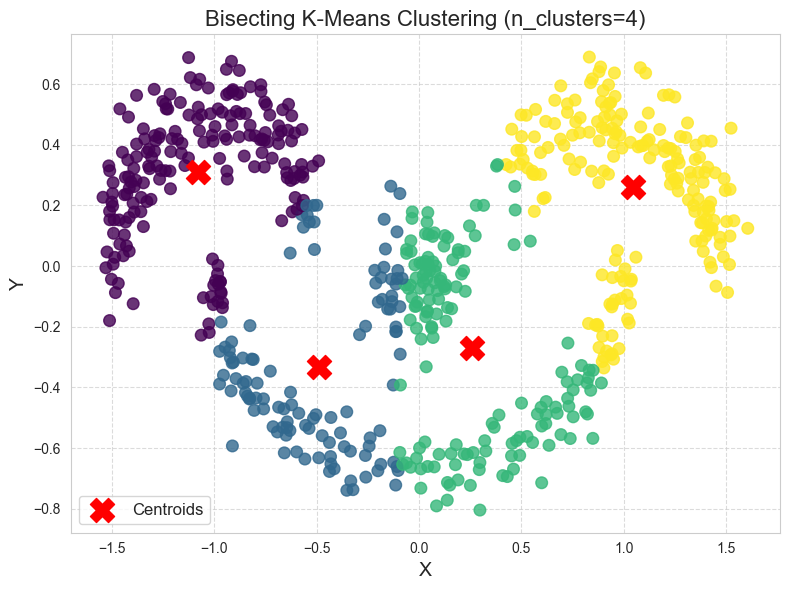

In [7]:
# BisectingKMeansClustering (sklearn)

from sklearn.cluster import BisectingKMeans

import seaborn as sns

import matplotlib.pyplot as plt



# Assuming X is already defined

bisect_means = BisectingKMeans(n_clusters=4, random_state=5, algorithm='lloyd', bisecting_strategy='biggest_inertia').fit(X_smiling)

labels = bisect_means.labels_  # Cluster labels for each point

centers = bisect_means.cluster_centers_  # Centroids of the clusters



sns.set_style('whitegrid')

plt.figure(figsize=(8, 6))



# Plot each point, color-coded by cluster label

plt.scatter(X_smiling[:, 0], X_smiling[:, 1], c=labels, cmap='viridis', s=70, alpha=0.8)



# Plot centroids as red 'X'

plt.scatter(centers[:, 0], centers[:, 1], c='red', marker='X', s=300, label='Centroids')



plt.xlabel("X", fontsize=14)

plt.ylabel("Y", fontsize=14)

plt.title("Bisecting K-Means Clustering (n_clusters=4)", fontsize=16)  # Corrected to 4

plt.legend(fontsize=12)

plt.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()

plt.show()

In [8]:
clustering.create_gif("BisectingKmeansClustering_SmillingFace.gif")

## t4.8k

In [9]:
# Load data

file_path = '../2D_Data/t4.8k.csv'

X_t48k = data = pd.read_csv(file_path, header=None, delim_whitespace=True).values

C:\Users\khoah\AppData\Local\Temp\ipykernel_2200\4098266775.py:5: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  X_t48k = data = pd.read_csv(file_path, header=None, delim_whitespace=True).values


In [10]:
# KMeans + Divisive Clustering

clustering = BisectingKmeansClustering(X_t48k, max_clusters=6)

clustering.fit()

clustering.interactive()

clustering.create_gif("BisectingKmeansClustering_t48k.gif")

interactive(children=(IntSlider(value=0, description='step', max=5), Output()), _dom_classes=('widget-interact…

In [11]:
"""
# Initialize the class with data

clustering = MSTDivisiveClustering(X_t48k, max_clusters=6, max_cuts=6)

clustering.divisive_clustering_mst_interactive()

clustering.create_gif("mst_t48k.gif")
"""

'\n# Initialize the class with data\n\nclustering = MSTDivisiveClustering(X_t48k, max_clusters=6, max_cuts=6)\n\nclustering.divisive_clustering_mst_interactive()\n\nclustering.create_gif("mst_t48k.gif")\n'

## Aggregation

In [12]:
# Load data

file_path = '../2D_Data/Aggregation.csv'

X_Aggregation = data = pd.read_csv(file_path, header=None, delim_whitespace=True).values

C:\Users\khoah\AppData\Local\Temp\ipykernel_2200\4211186796.py:5: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  X_Aggregation = data = pd.read_csv(file_path, header=None, delim_whitespace=True).values


In [13]:
# KMeans + Divisive Clustering

clustering = BisectingKmeansClustering(X_Aggregation, max_clusters=5)

clustering.fit()

clustering.interactive()

clustering.create_gif("BisectingKmeansClustering_Aggregation.gif")

interactive(children=(IntSlider(value=0, description='step', max=4), Output()), _dom_classes=('widget-interact…

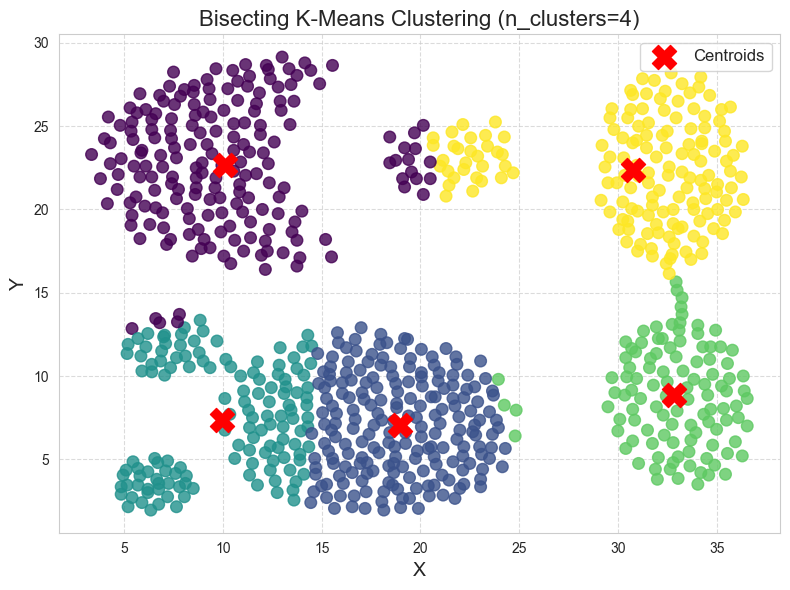

In [14]:
# BisectingKMeansClustering (sklearn)



bisect_means = BisectingKMeans(n_clusters=5, random_state=5, algorithm='lloyd', bisecting_strategy='biggest_inertia').fit(X_Aggregation)

labels = bisect_means.labels_  # Cluster labels for each point

centers = bisect_means.cluster_centers_  # Centroids of the clusters



sns.set_style('whitegrid')

plt.figure(figsize=(8, 6))



# Plot each point, color-coded by cluster label

plt.scatter(X_Aggregation[:, 0], X_Aggregation[:, 1], c=labels, cmap='viridis', s=70, alpha=0.8)



# Plot centroids as red 'X'

plt.scatter(centers[:, 0], centers[:, 1], c='red', marker='X', s=300, label='Centroids')



plt.xlabel("X", fontsize=14)

plt.ylabel("Y", fontsize=14)

plt.title("Bisecting K-Means Clustering (n_clusters=4)", fontsize=16)  # Corrected to 4

plt.legend(fontsize=12)

plt.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()

plt.show()

In [15]:
# Perform divisive clustering using MST approach



clustering = MSTDivisiveClustering(X_Aggregation, max_clusters=5, max_cuts=5)



# 1. To view the interactive clustering:

clustering.divisive_clustering_mst_interactive()



# 2. To generate and save the clustering process as a GIF:

clustering.create_gif("mst_Aggregation.gif")

interactive(children=(IntSlider(value=0, description='Step', max=5), Output()), _dom_classes=('widget-interact…

C:\Users\khoah\AppData\Local\Temp\ipykernel_2200\1901483456.py:261: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap('viridis', len(clusters))
